In [1]:
import numpy as np
from scipy.optimize import fsolve, root
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import pandas as pd
import progressbar
%matplotlib inline
import time
import pylab as pl
from IPython import display

In [2]:
def FrmaxJirka(H,hr):
    """Calculates theoretical Frmax as in Jirka (1979)
    Input: total height H and height hr of salt layer far from screen"""
    return pow(H/hr,5/2)*pow(1+np.sqrt(H/hr-1),-2)

def loadcsvfile(filename, path='data/', delimiter=';'):
    exceldata = pd.read_excel(path+filename)
    exceldata.to_csv(path+'csv/'+filename[:-5]+'.csv', sep=delimiter, index=None, header=True)
    csvdata = pd.read_csv(path+'csv/'+filename[:-5]+'.csv', delimiter=delimiter)
    csvdata = csvdata.iloc[1:]
    csvdata.index -= 1
    for key in csvdata:
        if key != 'experiment':
            csvdata[key] = csvdata[key].astype('float')
    return csvdata

In [3]:
HaEl1 = loadcsvfile('Harleman_Elder_1.xlsx')
HaEl2 = loadcsvfile('Harleman_Elder_2.xlsx')
NL1204 = loadcsvfile('Noordland_M1204.xlsx')
IJ = loadcsvfile('IJmuiden.xlsx')

In [4]:
rho_1 = 1000
rho_2 = 1022
Drho = rho_2 - rho_1
eps = Drho/rho_2
g = 9.81
gp = g*eps
#H_T = 1
#H2 = 0.5*H_T
#H1 = H_T - H2

H = 1
hr = 0.3*H

In [5]:
def myFunction(f):
    q1 = f[0]
    q2 = f[1]
    hc = f[2]
    
    F = np.zeros(3)
    F[0] = q1**2/(gp*(H-hc)**3) + q2**2/(gp*hc**3) - 1
    #F[0] = q1**2/(gp*(H-hc)**3) - (1-eps*q1**2/(gp*(H-hc)**3))*(1-q2**2/(gp*hc**3))
    F[1] = hr - hc - q2**2/(2*gp*hc**2) + q1**2/(2*gp*(H-hc)**2)
    F[2] = q1 - lam*(q1+q2)
    return F

In [6]:
#lam_arr = np.linspace(0,0.9,10000)
dlam = 0.0001
lam_arr = np.concatenate([np.linspace(0,1-hr/H-dlam,10000),
                          np.linspace(1-hr/H-dlam,1-hr/H+dlam,100000),
                          np.linspace(1-hr/H+dlam,0.9,10000)])

f = pd.DataFrame({'q1': np.zeros(len(lam_arr)),
                  'q2': np.zeros(len(lam_arr)),
                  'hc': np.zeros(len(lam_arr)),
                  'Fr': np.zeros(len(lam_arr)),
                  'lam': lam_arr})
ffun = np.zeros((len(lam_arr),3))

q1_ini = 0
q2_ini = (2/3)**(3/2)*np.sqrt(gp*hr**3)
hc_ini = 2/3*hr
fGuess = np.array([q1_ini,q2_ini,hc_ini])
options = {'ftol': 1e-15, 'maxiter': int(10000)}
#options = {'xtol': 0.00001, 'maxfev': int(1e4)} #hybr
#options = {}
for ii in progressbar.progressbar(range(len(lam_arr))):
    lam = lam_arr[ii]
    fsol = root(myFunction, fGuess, method='lm', options=options)
    ffun[ii] = fsol.fun
    #print(ii, fsol.message)
    if fsol.success == False:
        print('Failed at step {}'.format(ii))
        print('Iterations: {}'.format(fsol.nfev))
        print('lambda = {}'.format(lam))
        print('message:', fsol.message)
        break
    q1, q2, hc = fsol.x
    f.q1[ii], f.q2[ii], f.hc[ii] = q1, q2, hc
    if (lam < 1-hr/H - dlam) or (lam > 1-hr/H + dlam):
        fGuess = np.array([q1,q2,hc])
    else:
        fGuess = np.array([1-hr/H,q2_ini,hc_ini])

f['F1'] = f.q1/np.sqrt(gp*(H-f.hc)**3)
f['F2'] = f.q2/np.sqrt(gp*f.hc**3)
f['Fr'] = (f.q1+f.q2) / np.sqrt(gp*hr**3)

100% (120000 of 120000) |################| Elapsed Time: 0:02:16 Time:  0:02:16


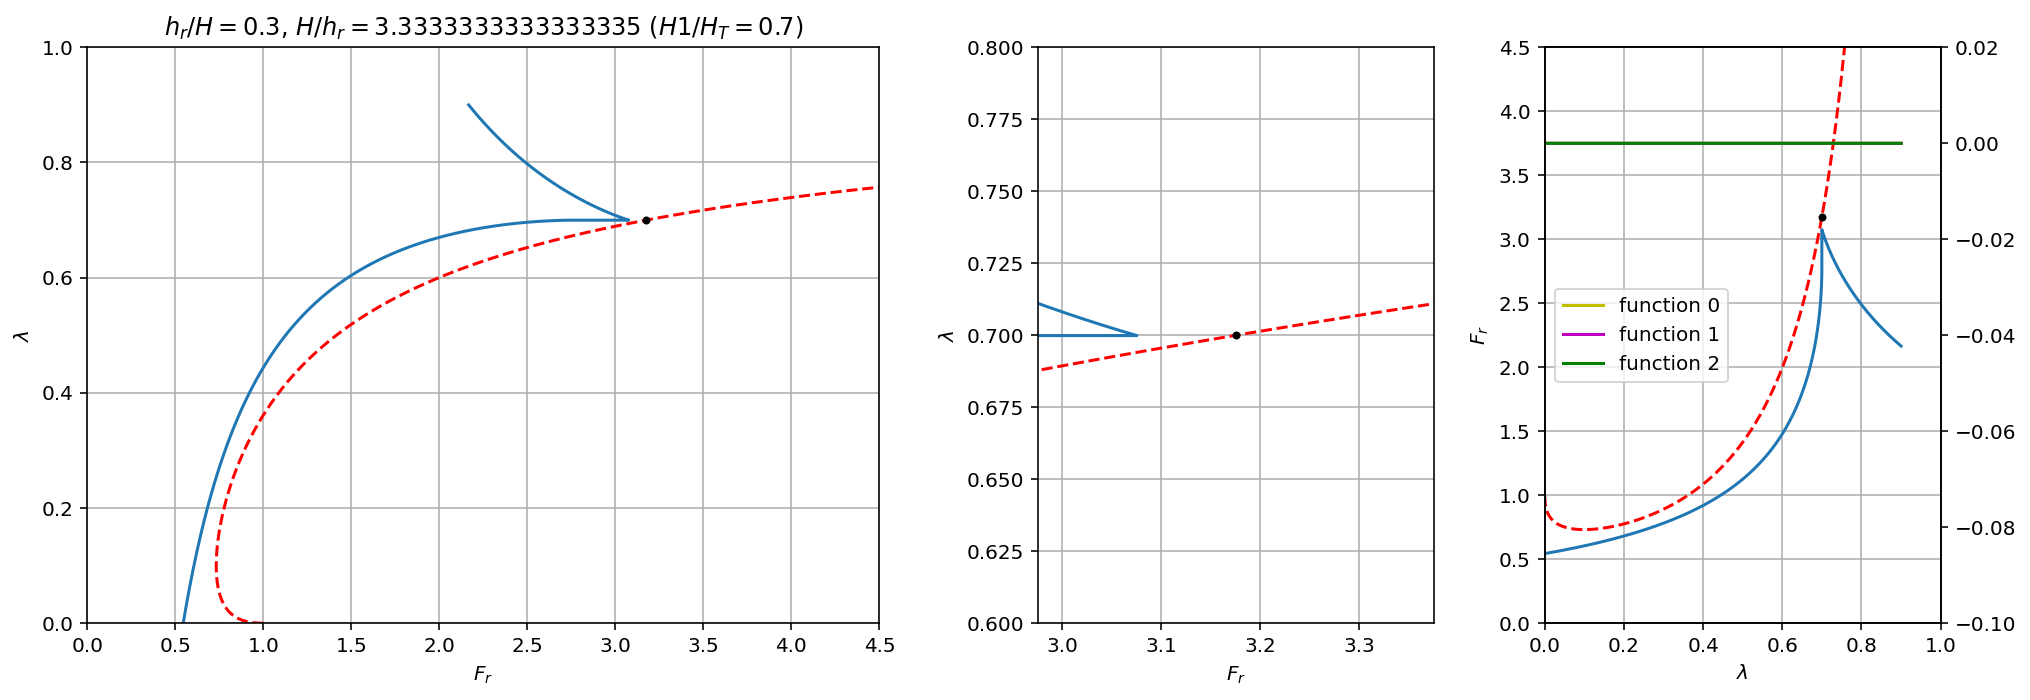

In [7]:
Frmaxtheory = FrmaxJirka(H,hr)

figprops = dict(figsize=(11, 8), dpi=144)
fig = plt.figure(**figprops)

ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel='$F_r$', ylabel='$\lambda$', title='$h_r/H = {0}$, $H/h_r = {1}$ ($H1/H_T = {2}$)'.format(hr/H,H/hr, (H-hr)/H))
ax.axis([0,4.5,0,1])
ax.grid()

bx = plt.axes([.6, 0, .25, .5])
bx.set(xlabel='$F_r$', ylabel='$\lambda$', title='')
bx.axis([Frmaxtheory-.2,Frmaxtheory+.2,1-hr/H-.1,1-hr/H+.1])
bx.grid()

cx = plt.axes([.92, 0, .25, .5])
cx.set(xlabel='$\lambda$', ylabel='$F_r$', title='')
cx.axis([1-hr/H-.1,1-hr/H+.1,Frmaxtheory-.2,Frmaxtheory+.2])
cx.axis([0,1,0,4.5])
cx.grid()

lammax = np.linspace(0,0.99,1000)
Frmax = pow(1-lammax, -5/2)*pow(1+np.sqrt(lammax/(1-lammax)),-2)
                                                                                                                       
ax.plot(f.Fr, f.lam, '-')
#ax.plot(0.15, 0.24, 'or')
ax.plot(Frmax, lammax, '--r', label='$F_{r_{max}}$')
ax.plot(Frmaxtheory, 1-hr/H, '.k')

bx.plot(f.Fr, f.lam, '-')
bx.plot(Frmax, lammax, '--r', label='$F_{r_{max}}$')
bx.plot(Frmaxtheory, 1-hr/H, '.k')

cx.plot(f.lam, f.Fr, '-')
cx.plot(lammax, Frmax, '--r', label='$F_{r_{max}}$')
cx.plot(1-hr/H, Frmaxtheory, '.k')

cx2 = cx.twinx()
cx2.set_ylim([-0.1,0.02])
cx2.plot(lam_arr, ffun[:,0], 'y', label='function 0')
cx2.plot(lam_arr, ffun[:,1], 'm', label='function 1')
cx2.plot(lam_arr, ffun[:,2], 'g', label='function 2')
cx2.legend(loc='center left')

plt.show()

# Initialise on $F_{r_{max}}$

First step:

###### comments: als hr/H=0.7, dan werkt hc_ini=2/3*H*lam als goede initial guess, maar als hr/H=0.3, dan werkt hc_ini = hr beter...

q1 = 0.02409037240286781 --- q1_ini = 0.028721056646856445
q2 = 0.21681335162581036 ---- q2_ini = 0.2584895098217081
hc = 0.6162040603780009 ---- hc_ini = 0.6
lam = 0.09999999999999996 --- lam_ini = 0.09999999999999998
[ 0.00000000e+00 -3.81639165e-17 -3.46944695e-18]


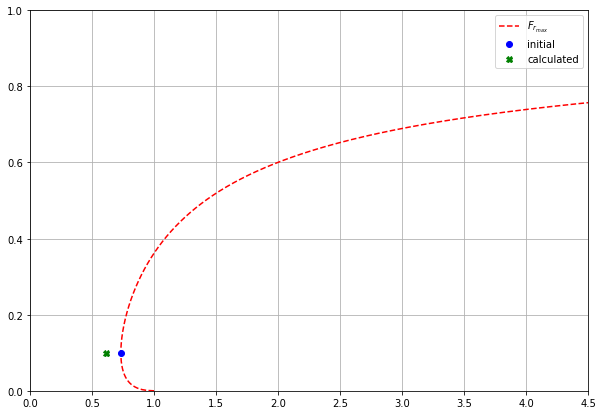

In [8]:
H = 1
hr = 0.9*H

lam_ini = 1-hr/H
lam = lam_ini
q_ini = FrmaxJirka(H,hr)*np.sqrt(eps*g*hr**3)
q1_ini = lam_ini*q_ini
q2_ini = q_ini - q1_ini
hc_ini = 2/3*H*lam
hc_ini = 2/3*hr
fGuess = np.array([q1_ini,q2_ini,hc_ini])
options = {'xtol':1e-50, 'ftol': 1e-50, 'maxiter': int(1e9)}
#options = {'xtol': 0.00001, 'maxfev': int(1e4)} #hybr
fsol = root(myFunction, fGuess, method='lm', options=options)
q1, q2, hc = fsol.x

print('q1 =',q1, '---', 'q1_ini =',q1_ini)
print('q2 =',q2, '----', 'q2_ini =',q2_ini)
print('hc =',hc, '----', 'hc_ini =',hc_ini)
print('lam =',q1/(q1+q2), '---', 'lam_ini =', q1_ini/(q1_ini+q2_ini))
print(fsol.fun)

plt.figure(figsize=(10,7))
plt.plot(Frmax, lammax, '--r', label='$F_{r_{max}}$')
plt.axis([0,4.5,0,1])
#plt.axis([0.8,1,0.2,0.4])
plt.plot(FrmaxJirka(H,hr), lam_ini, 'ob', label='initial')
plt.plot((q1+q2)/np.sqrt(eps*g*hr**3), q1/(q1+q2), 'Xg', label='calculated')
plt.legend()
plt.grid()

Loop one $h_r/H$:

In [9]:
H = 1
hr = 0.9*H

#initial values on Frmax from theory Jirka:
lam_ini = 1-hr/H
q_ini = FrmaxJirka(H,hr)*np.sqrt(eps*g*hr**3)
q1_ini = lam_ini*q_ini
q2_ini = q_ini - q1_ini
#hc_ini = 2/3*H*lam_ini if hr/H>=0.5 else hr
hc_ini = 0.1
lam_arr = np.linspace(lam_ini,0,1000)
#lam_arr = np.linspace(lam_ini,1,1000)

# empty dataframe to save outputs
f = pd.DataFrame({'q1': np.zeros(len(lam_arr)),
                  'F1': np.zeros(len(lam_arr)),
                  'q2': np.zeros(len(lam_arr)),
                  'F2': np.zeros(len(lam_arr)),
                  'hc': np.zeros(len(lam_arr)),
                  'Fr': np.zeros(len(lam_arr)),
                  'lam': lam_arr})
ffun = np.zeros((len(lam_arr),3))

#options solver
fGuess = np.array([q1_ini,q2_ini,hc_ini])
method = 'lm'
if method == 'lm':
    options = {'xtol': 1e-10, 'ftol': 1e-20, 'maxiter': int(1e6)}
elif method == 'hybr':
    options = {'xtol': 1e-10, 'maxfev': int(1e6)} #hybr

for ii in progressbar.progressbar(range(len(lam_arr))):
    lam = lam_arr[ii]
    fsol = root(myFunction, fGuess, method=method, options=options)
    ffun[ii] = fsol.fun
    #print(ii, fsol.message)
    if fsol.success == False:
        print('Failed at step {}'.format(ii))
        print('Iterations: {}'.format(fsol.nfev))
        print('lambda = {}'.format(lam))
        print('message:', fsol.message)
        break
    q1, q2, hc = fsol.x
    f.q1[ii], f.q2[ii], f.hc[ii] = q1, q2, hc
    fGuess = np.array([q1,q2,hc])

    f.F1[ii] = q1/np.sqrt(gp*(H-hc)**3)
    f.F2[ii] = q2/np.sqrt(gp*hc**3)
    f.Fr[ii] = (q1+q2) / np.sqrt(gp*hr**3)

f = f.reindex(index=f.index[::-1]).reset_index(drop=True)
FrNS = np.linspace(f.Fr[len(f)-1],5,100)
lamNS = f.lam[len(f)-1]*np.ones(len(FrNS))
f = f.append(pd.DataFrame({'Fr': FrNS, 'lam': lamNS}), ignore_index=True)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


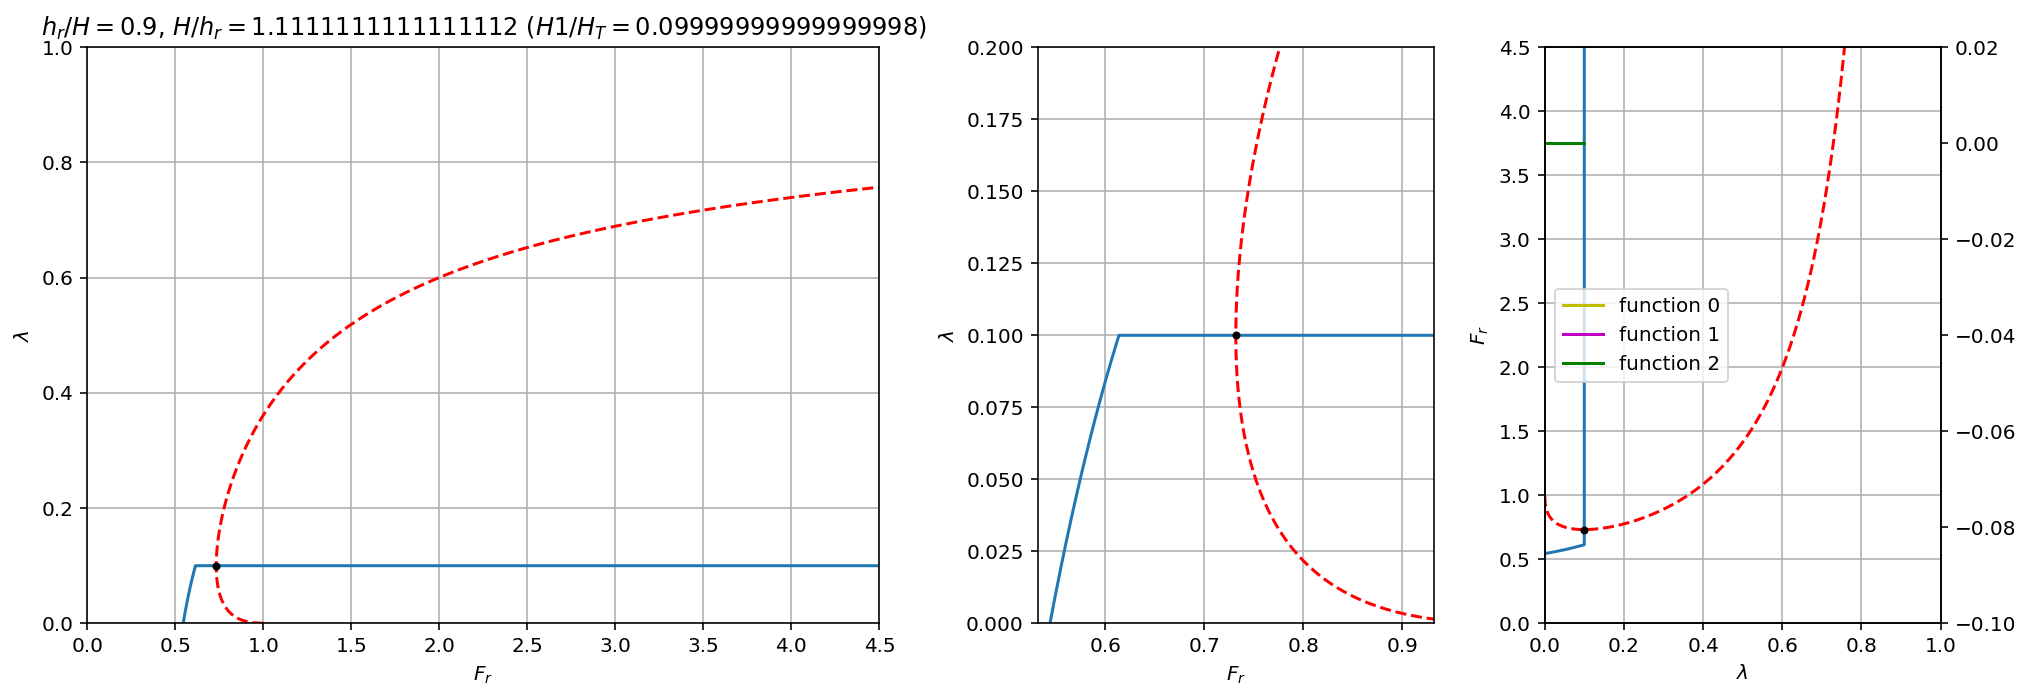

In [10]:
Frmaxtheory = FrmaxJirka(H,hr)

figprops = dict(figsize=(11, 8), dpi=144)
fig = plt.figure(**figprops)

ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel='$F_r$', ylabel='$\lambda$', title='$h_r/H = {0}$, $H/h_r = {1}$ ($H1/H_T = {2}$)'.format(hr/H,H/hr, (H-hr)/H))
ax.axis([0,4.5,0,1])
ax.grid()

bx = plt.axes([.6, 0, .25, .5])
bx.set(xlabel='$F_r$', ylabel='$\lambda$', title='')
bx.axis([Frmaxtheory-.2,Frmaxtheory+.2,1-hr/H-.1,1-hr/H+.1])
bx.grid()

cx = plt.axes([.92, 0, .25, .5])
cx.set(xlabel='$\lambda$', ylabel='$F_r$', title='')
cx.axis([1-hr/H-.1,1-hr/H+.1,Frmaxtheory-.2,Frmaxtheory+.2])
cx.axis([0,1,0,4.5])
cx.grid()

lammax = np.linspace(0,0.99,1000)
Frmax = pow(1-lammax, -5/2)*pow(1+np.sqrt(lammax/(1-lammax)),-2)
                                                                                                                       
ax.plot(f.Fr[len(f)-1], f.lam[len(f)-1], 'Xb')
ax.plot(f.Fr, f.lam, '-')
#ax.plot(0.15, 0.24, 'or')
ax.plot(Frmax, lammax, '--r', label='$F_{r_{max}}$')
ax.plot(Frmaxtheory, 1-hr/H, '.k')

bx.plot(f.Fr, f.lam, '-')
bx.plot(Frmax, lammax, '--r', label='$F_{r_{max}}$')
bx.plot(Frmaxtheory, 1-hr/H, '.k')

cx.plot(f.lam, f.Fr, '-')
cx.plot(lammax, Frmax, '--r', label='$F_{r_{max}}$')
cx.plot(1-hr/H, Frmaxtheory, '.k')

cx2 = cx.twinx()
cx2.set_ylim([-0.1,0.02])
cx2.plot(lam_arr, ffun[:,0], 'y', label='function 0')
cx2.plot(lam_arr, ffun[:,1], 'm', label='function 1')
cx2.plot(lam_arr, ffun[:,2], 'g', label='function 2')
cx2.legend(loc='center left')

plt.show()

# Jirka figures

In [11]:
hr_arr = np.array([0.25, 0.375, 0.5, 0.625, 0.75, 0.9])*H
ff = pd.DataFrame({})

for hr in hr_arr:
    print('hr =',hr)

    H = 1
    #hr = 0.7*H

    #initial values on Frmax from theory Jirka:
    lam_ini = 1-hr/H
    q_ini = FrmaxJirka(H,hr)*np.sqrt(eps*g*hr**3)
    q1_ini = lam_ini*q_ini
    q2_ini = q_ini - q1_ini
    hc_ini = 2/3*H*lam_ini if hr/H>=0.5 else 2/3*hr
    lam_arr = np.linspace(lam_ini,0,1000)
    #lam_arr = np.linspace(lam_ini,1,1000)

    # empty dataframe to save outputs
    f = pd.DataFrame({'q1': np.zeros(len(lam_arr)),
                      'F1': np.zeros(len(lam_arr)),
                      'q2': np.zeros(len(lam_arr)),
                      'F2': np.zeros(len(lam_arr)),
                      'hr': np.ones(len(lam_arr))*hr,
                      'hc': np.zeros(len(lam_arr)),
                      'Fr': np.zeros(len(lam_arr)),
                      'lam': lam_arr})
    ffun = np.zeros((len(lam_arr),3))

    #options solver
    fGuess = np.array([q1_ini,q2_ini,hc_ini])
    method = 'lm'
    if method == 'lm':
        options = {'xtol': 1e-10, 'ftol': 1e-20, 'maxiter': int(1e6)}
    elif method == 'hybr':
        options = {'xtol': 1e-10, 'maxfev': int(1e6)} #hybr

    for ii in progressbar.progressbar(range(len(lam_arr))):
        lam = lam_arr[ii]
        fsol = root(myFunction, fGuess, method=method, options=options)
        ffun[ii] = fsol.fun
        #print(ii, fsol.message)
        if fsol.success == False:
            print('Failed at step {}'.format(ii))
            print('Iterations: {}'.format(fsol.nfev))
            print('lambda = {}'.format(lam))
            print('message:', fsol.message)
            break
        q1, q2, hc = fsol.x
        f.q1[ii], f.q2[ii], f.hc[ii] = q1, q2, hc
        fGuess = np.array([q1,q2,hc])

        f.F1[ii] = q1/np.sqrt(gp*(H-hc)**3)
        f.F2[ii] = q2/np.sqrt(gp*hc**3)
        f.Fr[ii] = (q1+q2) / np.sqrt(gp*hr**3)

    f = f.reindex(index=f.index[::-1]).reset_index(drop=True)
    FrNS = np.linspace(f.Fr[len(f)-1],5,100)
    lamNS = f.lam[len(f)-1]*np.ones(len(FrNS))
    f = f.append(pd.DataFrame({'Fr': FrNS, 'lam': lamNS, 'hr': np.ones(len(FrNS))*hr}), ignore_index=True)
    ff = ff.append(f)

  6% (64 of 1000) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:02

hr = 0.25


100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
  5% (51 of 1000) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:02

hr = 0.375


100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
  2% (26 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:01:38

hr = 0.5


100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
 11% (114 of 1000) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:01

hr = 0.625


100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
 10% (102 of 1000) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:01

hr = 0.75


100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
 11% (114 of 1000) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:01

hr = 0.9


100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


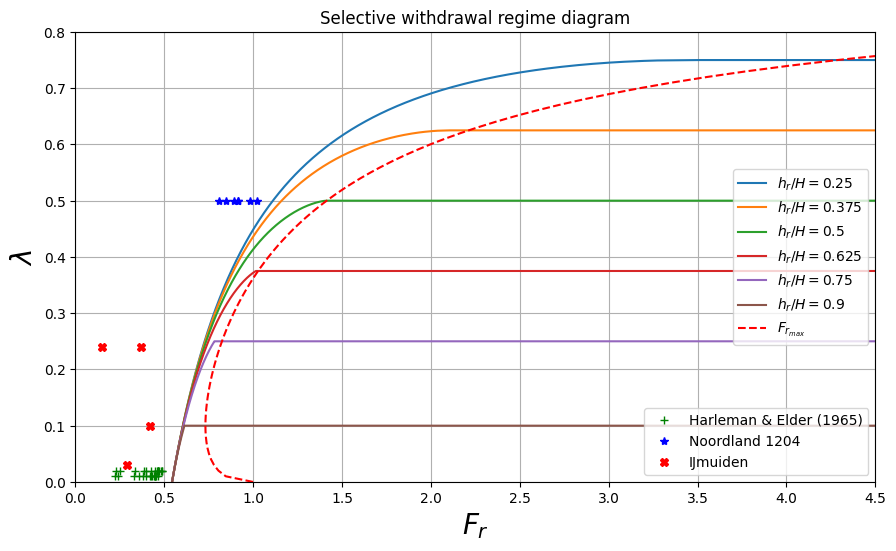

In [18]:
figprops = dict(figsize=(16, 9), dpi=100)
fig = plt.figure(**figprops)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels

ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel='$F_r$', ylabel='$\lambda$', title='Selective withdrawal regime diagram')
ax.axis([0,4.5,0,.8])
ax.grid()

[ax.plot(ff.Fr[ff.hr==hr], ff.lam[ff.hr==hr], '-', label='$h_r/H={}$'.format(hr/H)) for hr in hr_arr]
lammax = np.linspace(0,0.99,100)
Frmax = pow(1-lammax, -5/2)*pow(1+np.sqrt(lammax/(1-lammax)),-2)
ax.plot(Frmax, lammax, '--r', label='$F_{r_{max}}$')

lgnd1 = ax.legend(title='', loc='center right')

HaElplot, = ax.plot(pd.concat([HaEl1.Fr, HaEl2.Fr]), pd.concat([HaEl1.lam, HaEl2.lam]), '+g')
#sel = np.where(NL1204.D<2/3*NL1204.hr)[0]
sel = np.array([92,4,38,122,136,98,44])
NL1204plot, = ax.plot(NL1204.iloc[sel].Fr, NL1204.iloc[sel].lam, '*b')
#NL1204plot, = ax.plot(NL1204.Fr, NL1204.lam, '*b')
IJplot, = ax.plot(IJ.Fr, IJ.lam, 'Xr')
lgnd2 = ax.legend([HaElplot, NL1204plot, IJplot], ['Harleman & Elder (1965)', 'Noordland 1204', 'IJmuiden'], loc='lower right')
ax.add_artist(lgnd1)

plt.show()

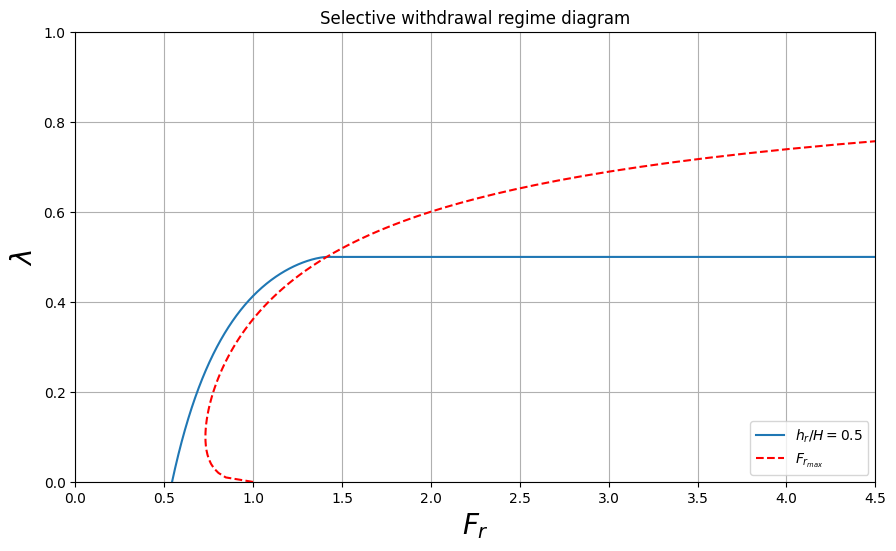

In [49]:
figprops = dict(figsize=(16, 9), dpi=100)
fig = plt.figure(**figprops)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels

ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel='$F_r$', ylabel='$\lambda$', title='Selective withdrawal regime diagram')
ax.axis([0,4.5,0,1])
ax.grid()

ax.plot(ff.Fr[ff.hr==0.5], ff.lam[ff.hr==0.5], '-', label='$h_r/H={}$'.format(0.5/H))
lammax = np.linspace(0,0.99,100)
Frmax = pow(1-lammax, -5/2)*pow(1+np.sqrt(lammax/(1-lammax)),-2)
ax.plot(Frmax, lammax, '--r', label='$F_{r_{max}}$')

lgnd1 = ax.legend(title='', loc='lower right')

plt.show()

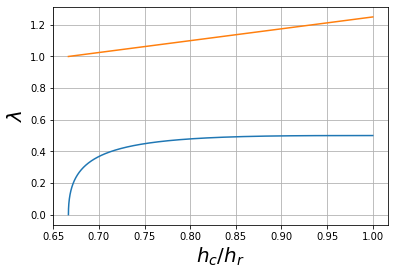

In [162]:
plt.plot(ff.hc[ff.hr==0.5]/0.5, ff.lam[ff.hr==0.5])
hrFan = 0.5
hcFan = np.linspace(2/3*hrFan,hrFan,1000)
c0c2Fan = 0.5*(1 - 3/2*hcFan/hrFan)
lamFan = 1-c0c2Fan
plt.plot(hcFan/hrFan, lamFan)

plt.gca().set(xlabel="$h_c/h_r$", ylabel="$\lambda$")
plt.grid()
plt.show()

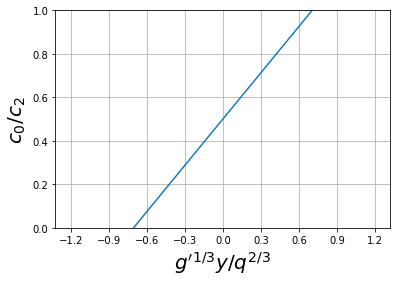

In [113]:
G2yFan = np.linspace(-1.2,1.2,1000)
c0c2Fan = 0.5+0.71*G2yFan
plt.plot(G2yFan, c0c2Fan)
plt.grid()
plt.gca().set(xlabel="$g'^{1/3}y/q^{2/3}$", ylabel="$c_0/c_2$")
plt.ylim([0,1])
plt.xticks(np.arange(-1.2,1.21,0.3))
plt.show()

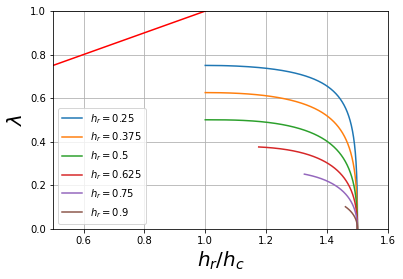

In [14]:
hrFan = 0.5
hcFan = np.linspace(hrFan,1,1000)
lamFan = 0.5+0.5*hrFan/hcFan
#plt.plot((ff.hc[ff.hr==0.5])/0.5, ff.lam[ff.hr==0.5], label="$h_r={}$".format(0.5))
#plt.plot((ff.hc[ff.hr==0.9])/0.9, ff.lam[ff.hr==0.9], label="$h_r={}$".format(0.9))
#plt.plot((ff.hc[ff.hr==0.25])/0.25, ff.lam[ff.hr==0.25], label="$h_r={}$".format(0.25))
[plt.plot(hr/(ff.hc[ff.hr==hr]), ff.lam[ff.hr==hr], label="$h_r={}$".format(hr)) for hr in hr_arr]
plt.plot(hrFan/hcFan, lamFan, 'r')

plt.gca().set(xlabel="$h_r/h_c$", ylabel="$\lambda$")
plt.axis([0.5,1.6,0,1])
plt.legend()
plt.grid()
plt.show()

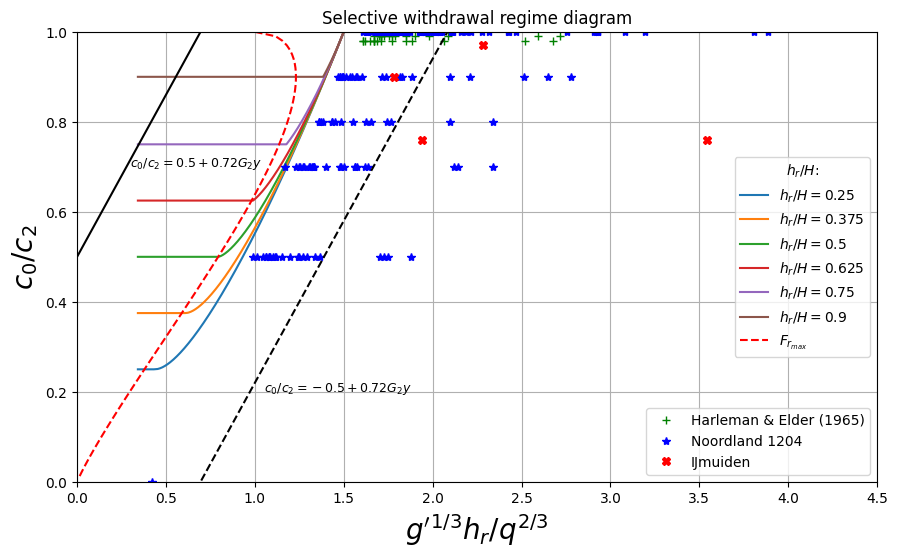

In [17]:
figprops = dict(figsize=(16, 9), dpi=100)
fig = plt.figure(**figprops)

ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel="$g'^{1/3}h_r/q^{2/3}$", ylabel='$c_0/c_2$', title='Selective withdrawal regime diagram')
ax.axis([0,4.5,0,1])
ax.grid()

[ax.plot(pow(ff.Fr[ff.hr==hr],-2/3), 1-ff.lam[ff.hr==hr], '-', label='$h_r/H={}$'.format(hr/H)) for hr in hr_arr]
lammax = np.linspace(0,0.99,100)
Frmax = pow(1-lammax, -5/2)*pow(1+np.sqrt(lammax/(1-lammax)),-2)
ax.plot(pow(Frmax,-2/3), 1-lammax, '--r', label='$F_{r_{max}}$')

lgnd1 = ax.legend(title='$h_r/H$:', loc='center right')

HaElplot, = ax.plot(pd.concat([pow(HaEl1.Fr,-2/3), pow(HaEl2.Fr,-2/3)]), pd.concat([1-HaEl1.lam, 1-HaEl2.lam]), '+g')
#sel = np.where(NL1204.D<2/3*NL1204.hr)[0]
#NL1204plot, = ax.plot(NL1204.iloc[sel].Fr, NL1204.iloc[sel].lam, '*b')
NL1204plot, = ax.plot(pow(NL1204.Fr,-2/3), 1-NL1204.lam, '*b')
IJplot, = ax.plot(pow(IJ.Fr,-2/3), 1-IJ.lam, 'Xr')
lgnd2 = ax.legend([HaElplot, NL1204plot, IJplot], ['Harleman & Elder (1965)', 'Noordland 1204', 'IJmuiden'], loc='lower right')
ax.add_artist(lgnd1)

xFan = np.linspace(-1.2,5,1000)
c0c2Fan = (-0.5 + 0.72*xFan)
ax.plot(xFan, c0c2Fan, '--k')
ax.text(1.05,0.2,'$c_0/c_2=-0.5+0.72G_2y$', fontdict={'size': 9})

xFan = np.linspace(-1.2,5,1000)
c0c2Fan = (0.5 + 0.72*xFan)
ax.plot(xFan, c0c2Fan, 'k')
ax.text(.3,0.7,'$c_0/c_2=0.5+0.72G_2y$', fontdict={'size': 9})

plt.show()

In [18]:
IJ

,experiment,rhofrac,lam,Fr,Q1,q1,Q2,q2,q,level interface inlet,level interface screen,hr/H,H,hr
0,100A,0.015864,0.24,0.15,2.3,0.001153,7.6,0.003810,0.004962,-374.3,-389.9,0.32,0.573382,0.183482
1,300C,0.015864,0.03,0.29,1.0,0.000501,28.6,0.014336,0.014837,-315.6,-323.3,0.44,0.577321,0.254021
2,300D,0.015864,0.10,0.42,3.0,0.001504,26.6,0.013333,0.014837,-356.0,-376.6,0.35,0.579385,0.202785
3,300F,0.015864,0.24,0.37,7.0,0.003509,22.6,0.011328,0.014837,-334.4,-358.1,0.38,0.577581,0.219481


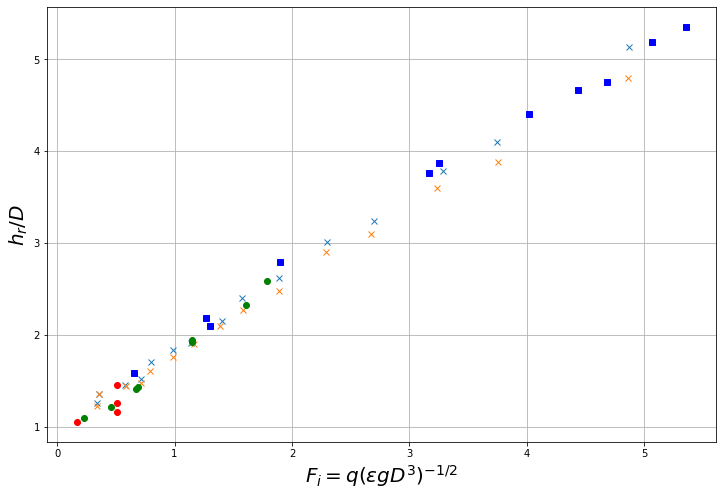

In [19]:
plt.figure(figsize=(12,8))
plt.plot(HaEl1.q/HaEl1.D/np.sqrt(HaEl1.rhofrac*9.81*HaEl1.D), HaEl1.hr/HaEl1.D, 'x')
plt.plot(HaEl2.q/HaEl2.D/np.sqrt(HaEl2.rhofrac*9.81*HaEl2.D), HaEl2.hr/HaEl2.D, 'x')

sel = np.arange(0,27) #referentieproeven D=3.1, L=1.35m, Drho=20
sel3 = NL1204.iloc[sel].iloc[np.where(NL1204.iloc[sel].lam==0)] #alle waar lambda=0
plt.plot(sel3.q/sel3.D/np.sqrt(sel3.rhofrac*9.81*sel3.D), 
         sel3.hr/sel3.D, 'sb')

sel = np.arange(27,47) #referentieproeven D=6.1cm, L=1.35m, Drho=20
sel6 = NL1204.iloc[sel].iloc[np.where(NL1204.iloc[sel].lam==0)] #alle waar lambda=0
plt.plot(sel6.q/sel6.D/np.sqrt(sel6.rhofrac*9.81*sel6.D), 
         sel6.hr/sel6.D, 'og')

DIJ = 17.5e-2
plt.plot(IJ.q/DIJ/np.sqrt(IJ.rhofrac*9.81*DIJ), 
         IJ.hr/DIJ, 'or')

plt.gca().set(xlabel="$F_i = q (\epsilon g D^3)^{-1/2}$", ylabel="$h_r/D$")

plt.grid()

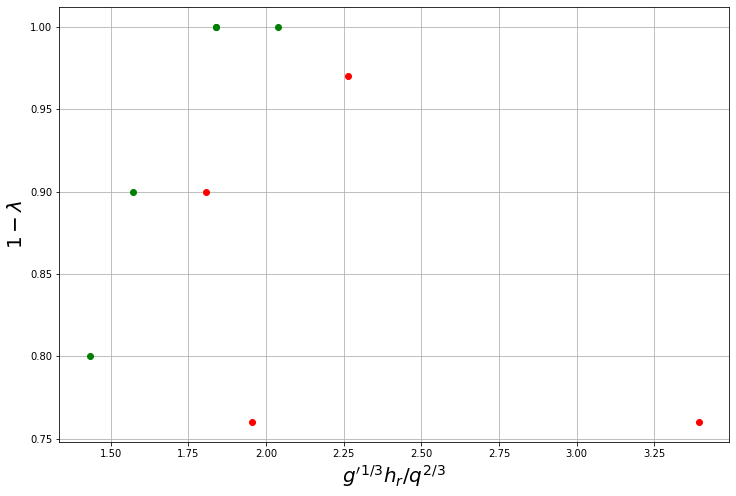

In [20]:
plt.figure(figsize=(12,8))
#plt.plot(pow(HaEl1.rhofrac*9.81,1/3)*HaEl1.hr/pow(HaEl1.q,2/3), 1-HaEl1.lam, 'x')
#plt.plot(pow(HaEl2.rhofrac*9.81,1/3)*HaEl2.hr/pow(HaEl2.q,2/3), 1-HaEl2.lam, 'x')

#sel = np.arange(0,27) #referentieproeven D=3.1, L=1.35m, Drho=20
#plt.plot(pow(NL1204.iloc[sel].rhofrac*9.81,1/3)*NL1204.iloc[sel].hr/pow(NL1204.iloc[sel].q,2/3), 1-NL1204.iloc[sel].lam, 'sb')

sel = np.arange(27,47) #referentieproeven D=6.1cm, L=1.35m, Drho=20
sel = np.arange(32,37)
#fit:
#x = pow(NL1204.iloc[sel].rhofrac*9.81,1/3)*NL1204.iloc[sel].hr/pow(NL1204.iloc[sel].q,2/3)
#y = 1-NL1204.iloc[sel].lam
#p = np.polyfit(x,y,1)
#xfit = np.linspace(0,10,1000)
#yfit = p[0]*xfit+p[1]
#plt.plot(xfit, yfit, '--r')
plt.plot(pow(NL1204.iloc[sel].rhofrac*9.81,1/3)*NL1204.iloc[sel].hr/pow(NL1204.iloc[sel].q,2/3), 1-NL1204.iloc[sel].lam, 'og')

plt.plot(pow(IJ.rhofrac*9.81,1/3)*IJ.hr/pow(IJ.q,2/3), 1-IJ.lam, 'or')

plt.gca().set(xlabel="$g'^{1/3}h_r/q^{2/3}$", ylabel="$1-\lambda$")
#plt.axis([1.5,3.5,0,1])
plt.grid()

In [21]:
8/(27*0.7**3)

0.8638375985314763